# GEOG696C Spatiotemporal Data Analytics: Term Project
## calcCorr_NLP.ipynb
This script compares the NLP time series of media flood reports against the precip and inundation data, at monthly time series. I perform a field correlation (i.e. time series of media reports versus spatiotemporal data of precip and inundation.)

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import math
import rasterio as rio
from rasterio.plot import show
from rasterio.mask import mask
import rioxarray as rx
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime, timezone
import scipy as sp
import cartopy
import cartopy.crs as ccrs 
import cartopy.feature as cfeature

In [2]:
# Set the root path
# rootPath = Path('/media/mule/Projects/NASA/NIP/Data')
rootPath = Path('C:/Users/alexsaunders/Documents/01_uoa/01_study/2023/geog696c/project/data')

In [3]:
font_dirs = ['C:/users/alexsaunders/appdata/local/microsoft/windows/fonts']
font_files = mpl.font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    mpl.font_manager.fontManager.addfont(font_file)

# set font
plt.rcParams['font.family'] = 'Work Sans'

## 1) Load the NLP data on the count of media reports

In [4]:
nlp=pd.read_csv('C:/Users/alexsaunders/Documents/01_uoa/04_git/dissertation/data/nlp/processed/ArticlesByDayByDivision.csv', index_col=0)#, keep_default_na=False)
nlp.index = pd.to_datetime(nlp.index)
nlp=nlp.iloc[:, :-5]
# nlp[nlp=='']=np.nan

### Create xarray and resample to monthly

In [5]:
divs=list(nlp.columns.str.capitalize())
times=list(nlp.index)

In [6]:
# Convert to xarray data array
nlpxr = xr.DataArray(
    nlp,
    coords={'time': times, 'division': divs},
    dims=['time', 'division']
)

In [7]:
# Set nans to zero since we want to use all data - maybe not the best assumption?
# nlpxr = nlpxr.fillna(0)

In [8]:
nlpMonthlyCount = nlpxr.resample(time='1M', skipna=True).sum(dim='time')

## 2) Load the precip and FIA data

In [9]:
chirpsPath=rootPath/'chirps'
rawPath=chirpsPath/'raw'
precip = xr.open_dataarray(chirpsPath/'xr/precip.nc')
precip

<xarray.DataArray (time: 1584, lat: 120, lon: 93)>
[17677440 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2001-01-01 2001-01-06 ... 2022-12-26
  * lat      (lat) float64 26.62 26.57 26.52 26.47 ... 20.82 20.77 20.72 20.67
  * lon      (lon) float64 88.03 88.08 88.13 88.18 ... 92.48 92.53 92.58 92.63

In [10]:
FIAPath = rootPath/'pixelFIA/xr/'
FIA = xr.open_dataarray(FIAPath/'pixelFIACountryCoarse.nc')
FIA = FIA.where(FIA!=-9999, np.nan)
FIA

<xarray.DataArray (lat: 122, lon: 94, time: 985)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * lat      (lat) float64 26.61 26.56 26.51 26.46 ... 20.78 20.73 20.68 20.63
  * lon      (lon) float64 88.03 88.08 88.13 88.18 ... 92.48 92.53 92.58 92.63
  * time     (time) datetime64[ns] 2001-06-13 2001-06-29 ... 2022-12-30

## 3) Resample precip and FIA to monthly max

In [11]:
precipMonthlyMax = precip.resample(time='1M', skipna=True).max(dim='time')

In [12]:
FIAMonthlyMax = FIA.resample(time='1M', skipna=True).max(dim='time')

In [13]:
# Change time to first dimension
FIAMonthlyMax=FIAMonthlyMax.transpose("time", "lat", "lon")

### Subset to overlapping time period (drop a few months in one dataset)

In [14]:
precipMonthlyMax=precipMonthlyMax[precipMonthlyMax.time.isin(FIAMonthlyMax.time)]

### Sum over whole country at each timestep

In [119]:
# precipMonthlyTotal=precipMonthlyMax.sum(dim=["lat", "lon"])

In [15]:
FIAWeeklyTotal=FIA.mean(dim=["lat", "lon"])
FIAMonthlyTotal=FIAWeeklyTotal.resample(time='1M', skipna=True).max(dim='time')

In [24]:
# precipWeeklyTotal=precip.sum(dim=["lat", "lon"])
# precipMonthlyTotal=precipWeeklyTotal.resample(time='1M', skipna=True).max(dim='time')
# precipMonthlyTotal=precipMonthlyTotal[precipMonthlyTotal.time.isin(FIAMonthlyMax.time)]

In [25]:
# But actually this is the maximum of the total pentad rainfall, we want total monthly rainfall, so take sum instead of max
precipWeeklyTotal=precip.sum(dim=["lat", "lon"])
precipMonthlyTotal=precipWeeklyTotal.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlyTotal=precipMonthlyTotal[precipMonthlyTotal.time.isin(FIAMonthlyMax.time)]

## 4) Quick plot of the respective time series, monthly steps

In [26]:
# Define the monsoon months for showing on plot
# Monsoon months = June-October inclusive, 6,7,8,9,10 every year
monsoonMonths=[6,10]
monsoons=[]
for year in list(range(2000,2023)):
    startMonth=pd.to_datetime(str(year)+'-'+str(monsoonMonths[0])+'-01')
    endMonth=pd.to_datetime(str(year)+'-'+str(monsoonMonths[1])+'-01')
    monsoons.append([startMonth,endMonth])
# monsoons

In [27]:
iplot=precipMonthlyMax.time

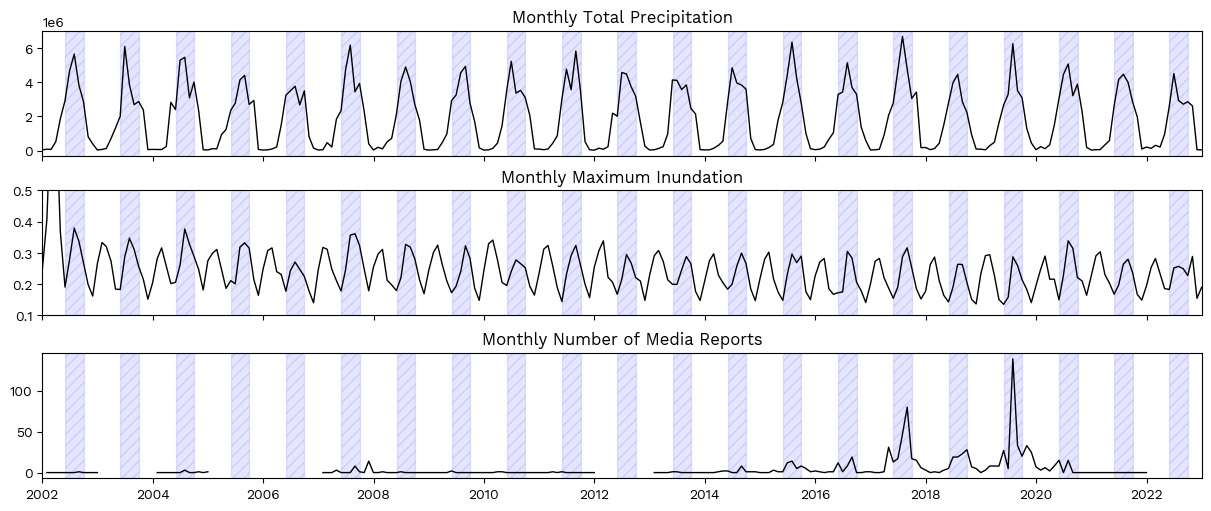

In [28]:
fig, axes = plt.subplots(3, 1, figsize=(12,5), sharex=True, constrained_layout=True)
names=['Monthly Total Precipitation', 'Monthly Maximum Inundation', 'Monthly Number of Media Reports']

# Precip
ax=axes[0]
ax.set_title(names[0])
ax.plot(iplot, precipMonthlyTotal, c= 'k', linewidth=1, label='Precipitation')
# ax.plot(iplot, precipMonthlyTotal3, c= 'r', linewidth=1, label='Precipitation')

# Inundation
ax=axes[1]
ax.set_title(names[1])
ax.plot(iplot, FIAMonthlyTotal, c= 'k', linewidth=1, label='Inundation')
ax.set_ylim(0.1, 0.5)

# NP
ax=axes[2]
ax.set_title(names[2])
ax.plot(nlpMonthlyCount.time, nlpMonthlyCount.sel(division='All'), c= 'k', linewidth=1, label='Media reports')
# ax.set_ylim(0.1, 0.5)

startPlot, endPlot = pd.to_datetime('2002-01-01'), pd.to_datetime('2022-12-31')
ax.set_xlim(startPlot, endPlot)


# Add monsoon fill
for ax in axes:
    for i, monsoon in enumerate(monsoons):
        ax.axvspan(monsoon[0], monsoon[1], alpha=0.1, color='blue', hatch='///', zorder=0, label='Monsoon')

plt.show()

__Take monsoon average? Or monsoon max?__

## Do field correlation
I.e. time series of NLP against spatiomteporal field of precip or inundation, monthly timesteps

__E.g.for precip, could use monthly max, or monthly sum?__

Or take the monsoon as a whole i.e. annual? But only have 6 timesteps then...

In [14]:
# Cut time series to 2015 onwards when NLP data is thought to be robust
startTime=pd.to_datetime('2015-01-01')
endTime=pd.to_datetime('2020-09-01')
nlpMonthlyCount = nlpxr.resample(time='1M', skipna=True).sum(dim='time')
nlpMonthly=nlpMonthlyCount.sel(time=slice(startTime, endTime))

In [15]:
precipMonthlySum = precip.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlySum = precipMonthlySum[precipMonthlySum.time.isin(nlpMonthly.time)]
precipMonthlyMax = precipMonthlyMax[precipMonthlyMax.time.isin(nlpMonthly.time)]

In [16]:
fieldCorrelPrecipSum = xr.corr(nlpMonthly, precipMonthlySum, dim="time")
fieldCorrelPrecipMax = xr.corr(nlpMonthly, precipMonthlyMax, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [17]:
print([div for div in divs])
print([np.nanmean(fieldCorrelPrecipSum.sel(division=div)) for div in divs])
print([np.nanmean(fieldCorrelPrecipMax.sel(division=div)) for div in divs])

['All', 'Barisal', 'Chittagong', 'Dhaka', 'Khulna', 'Rajshahi', 'Rangpur', 'Sylhet']
[0.4859320524812556, 0.41917118791724894, 0.4979272825201254, 0.4536859590377702, 0.3329964396934817, 0.4497272993125637, 0.4407490575656777, 0.44003495463881]
[0.4759249428887059, 0.4254371278875493, 0.4841239621953074, 0.4483677803633979, 0.3499191103393191, 0.4307601322700046, 0.4165071128825176, 0.43225997882968464]


### Plot the field correlaiton, for precip

In [18]:
# Function to get the extend argument
def getExtend(amin, amax, vmin, vmax):
    if amin<vmin and amax<=vmax:
        extend='min'
    elif amax>vmax and amin>=vmin:
        extend='max'
    elif amin<vmin and amax>vmax:
        extend='both'
    else:
        extend='neither'
    return extend

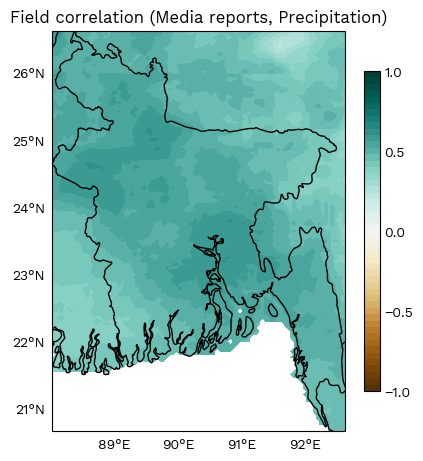

In [40]:
# Define data and arguments for plotting
plotData=fieldCorrelPrecipSum.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='Field correlation (Media reports, Precipitation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

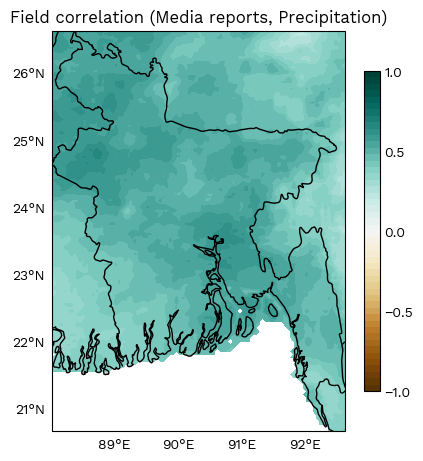

In [41]:
# Define data and arguments for plotting
plotData=fieldCorrelPrecipMax.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlyMax
titleName='Field correlation (Media reports, Precipitation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

### We can plot this separately for the media reports in each division

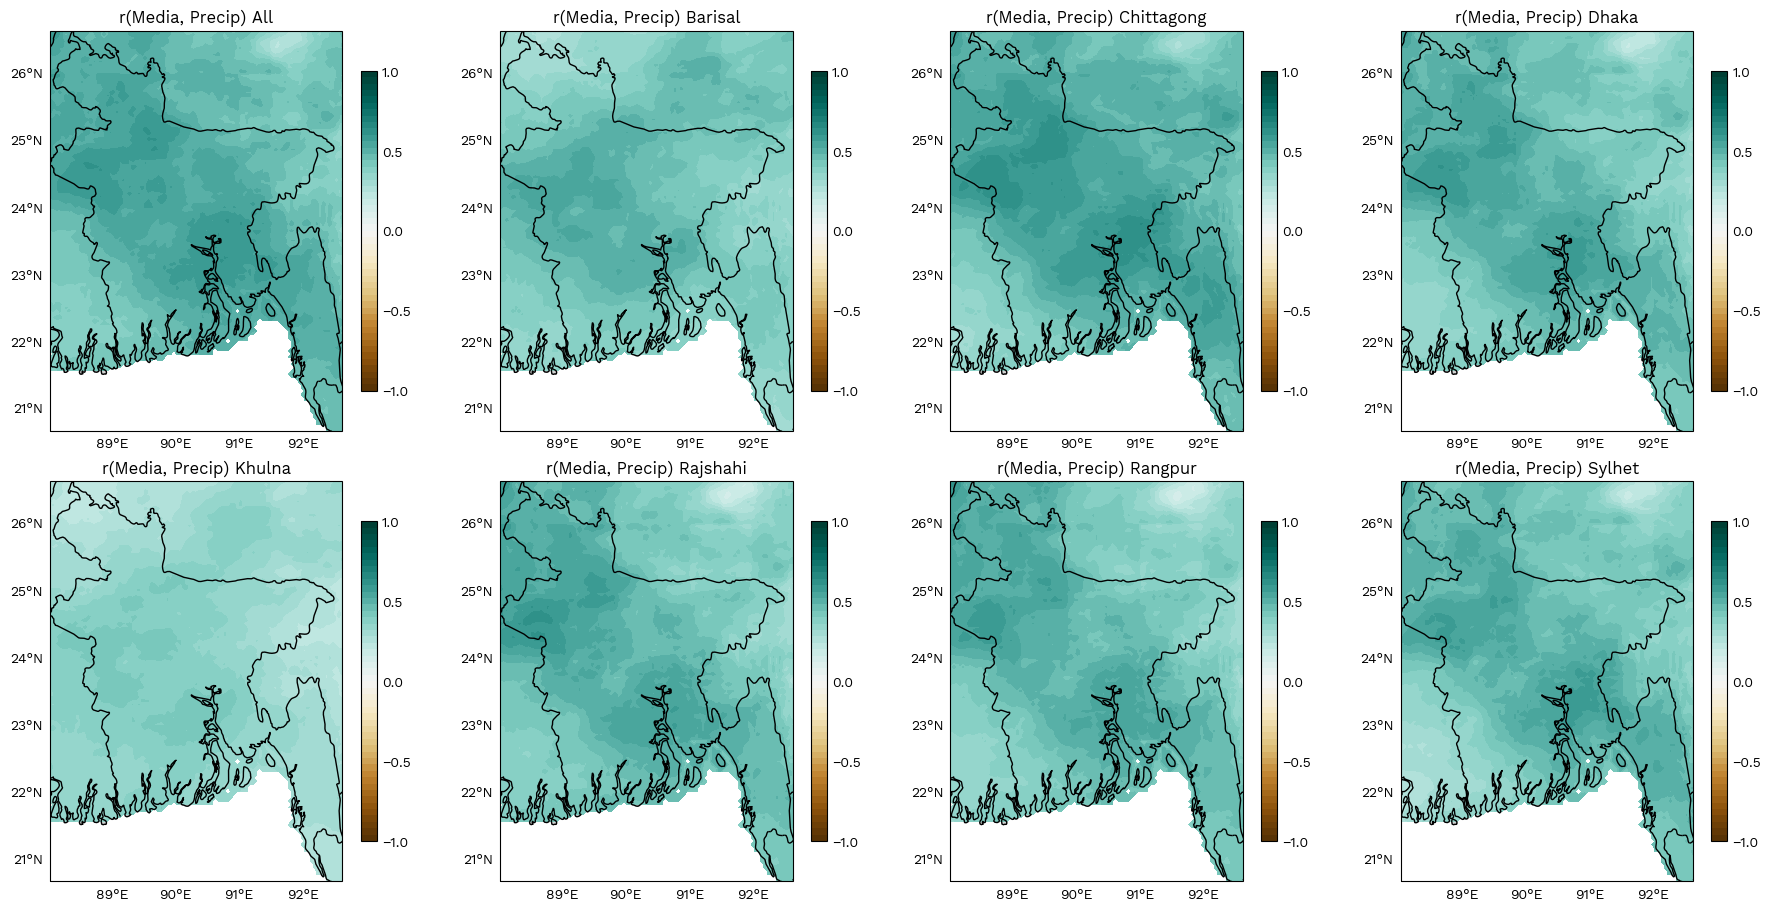

In [42]:
# Define data and arguments for plotting
plotDataAll=fieldCorrelPrecipSum#.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='r(Media, Precip)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=len(divs)
ncolsToPlot=4
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

for i, ax in enumerate(axes.ravel()):
    plotData=plotDataAll.sel(division=divs[i])
    ax.set_title('{0} {1}'.format(titleName, divs[i]))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

### Normalize the NLP data - not appropriatee?

In [43]:
# nlpMonthlyAnom = (nlpMonthly - nlpMonthly.mean(axis=0)) / nlpMonthly.std(axis=0)
# nlpMonthlyAnom.sel(division='All').plot()

### Detrend the NLP data - also not appropriate?

In [44]:
# nlpMonthlyAnomDetrended=sp.signal.detrend(nlpMonthlyAnom, type='linear')
# # Make back into an xarray
# # Convert to xarray data array
# nlpMonthlyAnomDetrended = xr.DataArray(
#     nlpMonthlyAnomDetrended,
#     coords={'time': nlpMonthlyAnom.time, 'division': nlpMonthlyAnom.division},
#     dims=['time', 'division']
# )
# nlpMonthlyAnomDetrended.sel(division='All').plot()

## Repeat field correlation with precip using detrended data

In [379]:
precipMonthlySum = precip.resample(time='1M', skipna=True).sum(dim='time')
precipMonthlySum = precipMonthlySum[precipMonthlySum.time.isin(nlpMonthlyAnomDetrended.time)]
precipMonthlyMax = precipMonthlyMax[precipMonthlyMax.time.isin(nlpMonthlyAnomDetrended.time)]

In [380]:
fieldCorrelPrecipSum = xr.corr(nlpMonthlyAnomDetrended, precipMonthlySum, dim="time")

In [381]:
print([div for div in divs])
print([np.nanmean(fieldCorrelPrecipSum.sel(division=div)) for div in divs])

['All', 'Barisal', 'Chittagong', 'Dhaka', 'Khulna', 'Rajshahi', 'Rangpur', 'Sylhet']
[0.05665643068924587, -0.0585756910094149, 0.14240428505861494, 0.033981083973883656, -0.13402621271154952, 0.06501260978140475, 0.05266989817494054, 0.0617246013319476]


In [382]:
fieldCorrelPrecipMax = xr.corr(nlpMonthlyAnomDetrended, precipMonthlyMax, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


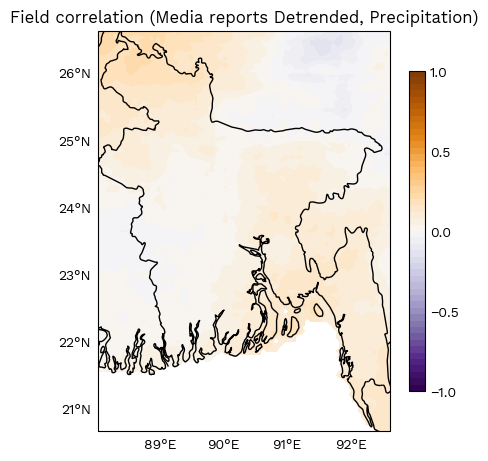

In [383]:
# Define data and arguments for plotting
plotData=fieldCorrelPrecipSum.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlySum
titleName='Field correlation (Media reports Detrended, Precipitation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

## Repeat for field correlation with inundation

In [19]:
FIAMonthlyMax = FIAMonthlyMax[FIAMonthlyMax.time.isin(nlpMonthly.time)]
fieldCorrelFIA = xr.corr(nlpMonthly, FIAMonthlyMax, dim="time")
# fieldCorrelFIADetrended = xr.corr(nlpMonthlyAnomDetrended, FIAMonthlyMaxCoarse, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\numpy\lib\nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [20]:
print([div for div in divs])
print([np.nanmean(fieldCorrelFIA.sel(division=div)) for div in divs])

['All', 'Barisal', 'Chittagong', 'Dhaka', 'Khulna', 'Rajshahi', 'Rangpur', 'Sylhet']
[0.06512660990184402, -0.021417150553943946, 0.06241685546897073, 0.08486801160731927, -0.0432540439838556, 0.1112086061286121, 0.13156125023100687, 0.07579825650526274]


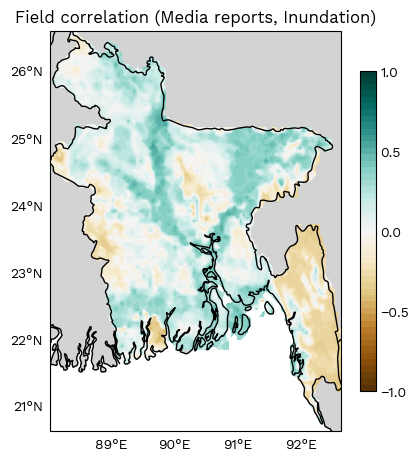

In [48]:
# Define data and arguments for plotting
plotData=fieldCorrelFIA.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=FIAMonthlyMax
titleName='Field correlation (Media reports, Inundation)'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

## Do field significance i.e. get p-values for all the r values we already have

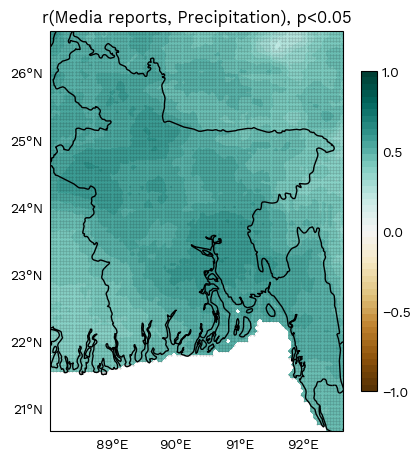

In [64]:
fieldCorrelation=fieldCorrelPrecipSum.sel(division='All').copy()

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(nlpMonthly.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(nlpMonthly.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])

# defines areas with sigificant coefficients
sig_area1   = np.where(sig < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# Define data and arguments for plotting
plotData=fieldCorrelPrecipSum.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlyMax
titleName='r(Media reports, Precipitation), p<0.05'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

# Add the significant areas
ax.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.5, c = 'k', alpha = 0.3, transform = ccrs.PlateCarree())
plt.show()

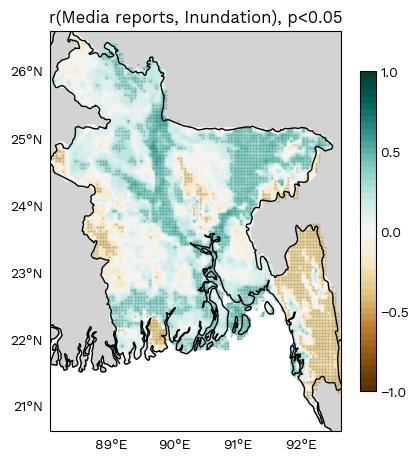

In [63]:
fieldCorrelation=fieldCorrelFIA.sel(division='All').copy()

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(nlpMonthly.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(nlpMonthly.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])

# defines areas with sigificant coefficients
sig_area1   = np.where(sig < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# Define data and arguments for plotting
plotData=fieldCorrelFIA.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=FIAMonthlyMax
titleName='r(Media reports, Inundation), p<0.05'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

# Add the significant areas
ax.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.5, c = 'k', alpha = 0.3, transform = ccrs.PlateCarree())
plt.show()

## Repeat field correlation, using spearmans's instead of pearson correlation
Because the NLP data is spikey, non-normal

In [22]:
import xskillscore

In [30]:
# fieldCorrelPrecipSum = xr.corr(nlpMonthly, precipMonthlySum, dim="time")
# fieldCorrelPrecipMax = xr.corr(nlpMonthly, precipMonthlyMax, dim="time")
fieldCorrelPrecipSumSp = xskillscore.spearman_r(nlpMonthly, precipMonthlySum, dim="time")

C:\Users\alexsaunders\Anaconda3\envs\geo_rioxarray38_\lib\site-packages\xskillscore\core\np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den


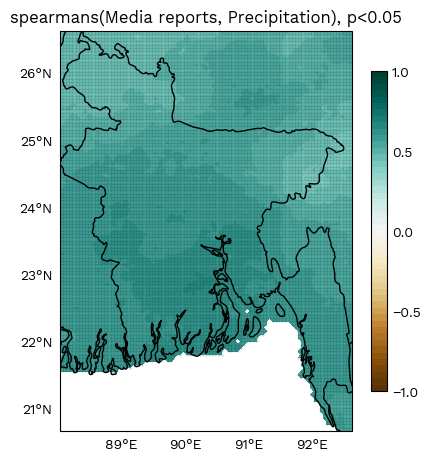

In [32]:
fieldCorrelation=fieldCorrelPrecipSumSp.sel(division='All').copy()

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(nlpMonthly.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(nlpMonthly.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])

# defines areas with sigificant coefficients
sig_area1   = np.where(sig < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# Define data and arguments for plotting
plotData=fieldCorrelPrecipSumSp.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=precipMonthlyMax
titleName='spearmans(Media reports, Precipitation), p<0.05'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

# Add the significant areas
ax.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.5, c = 'k', alpha = 0.3, transform = ccrs.PlateCarree())
plt.show()

In [24]:
# fieldCorrelFIA = xr.corr(nlpMonthly, FIAMonthlyMax, dim="time")
fieldCorrelFIASp = xskillscore.spearman_r(nlpMonthly, FIAMonthlyMax, dim="time")

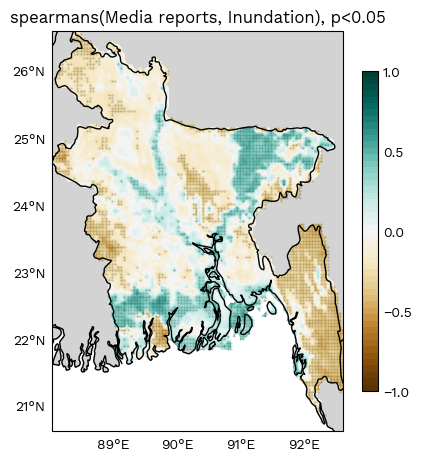

In [29]:
fieldCorrelation=fieldCorrelFIASp.sel(division='All').copy()

# calculate the p-values directly using r values and the t-distribution
t = -abs(fieldCorrelation.values)*np.sqrt((len(nlpMonthly.time)-2)/(1-np.square(fieldCorrelation.values)))
pvalue = sp.stats.t.cdf(t, len(nlpMonthly.time) - 2) * 2 # multiply by 2 for two-sided test
sig = xr.DataArray(data=pvalue,dims=["lat","lon"],coords=[fieldCorrelation.lat, fieldCorrelation.lon])

# defines areas with sigificant coefficients
sig_area1   = np.where(sig < 0.05) # this is a tuple! 
lons, lats = np.meshgrid(fieldCorrelation.lon,fieldCorrelation.lat)

# Define data and arguments for plotting
plotData=fieldCorrelFIASp.sel(division='All')#All
# plotData=fieldCorrelPrecipSum
coordsData=FIAMonthlyMax
titleName='spearmans(Media reports, Inundation), p<0.05'
vmin, vmax, nlevels, nlevelsCbar = -1, 1, 51, 5
amin, amax = np.nanmin(plotData), np.nanmax(plotData)
extend=getExtend(amin, amax, vmin, vmax)
cmap='BrBG'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=1
ncolsToPlot=1
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, ax = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})
# fig.suptitle('EOFs in Annual Max Precipitation, from CHIRPS 2001-2022')

# for i, ax in enumerate(axes.ravel()):
ax.set_title('{0}'.format(titleName))#, fontsize=16)
ax.coastlines(color='black') 
ax.add_feature(cfeature.LAND, color='lightgray')
ax.add_feature(cfeature.BORDERS)
ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                  y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
gl1.xlines=False
gl1.ylines=False
eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData, cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
cb1.ax.tick_params(size=0)

# Add the significant areas
ax.scatter(lons[sig_area1], lats[sig_area1], marker = '.', s = 0.5, c = 'k', alpha = 0.3, transform = ccrs.PlateCarree())
plt.show()

## Create composites of months of precip and inundation, for the top 10%ile and 5%ile of media reports months

In [67]:
pctile=0.9
thresh=np.quantile(nlpMonthly.sel(division='All'), pctile)
timesTop = nlpMonthly.time[np.where(nlpMonthly.sel(division='All') > thresh)]
FIAMonthlyMaxComp = FIAMonthlyMax[FIAMonthlyMax.time.isin(timesTop)].mean(dim="time")
precipMonthlyMaxComp = precipMonthlyMax[precipMonthlyMax.time.isin(timesTop)].mean(dim="time")
precipMonthlySumComp = precipMonthlySum[precipMonthlySum.time.isin(timesTop)].mean(dim="time")

In [68]:
pctile=0.95
thresh=np.quantile(nlpMonthly.sel(division='All'), pctile)
timesTop = nlpMonthly.time[np.where(nlpMonthly.sel(division='All') > thresh)]
FIAMonthlyMaxComp2 = FIAMonthlyMax[FIAMonthlyMax.time.isin(timesTop)].mean(dim="time")
precipMonthlyMaxComp2 = precipMonthlyMax[precipMonthlyMax.time.isin(timesTop)].mean(dim="time")
precipMonthlySumComp2 = precipMonthlySum[precipMonthlySum.time.isin(timesTop)].mean(dim="time")

### Plot the composites of the top 10%ile of media months, versus the mean of all months

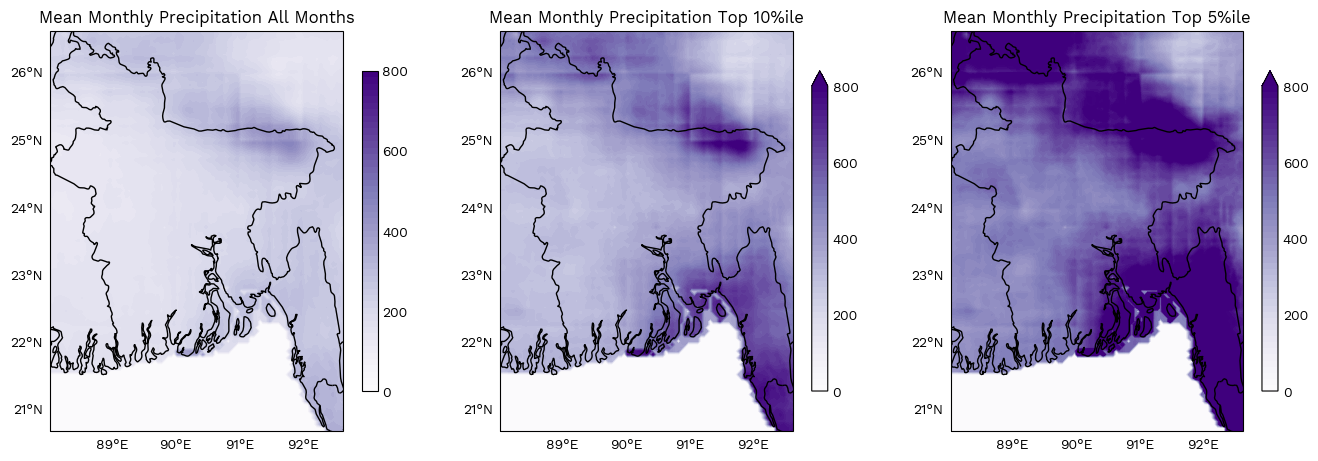

In [75]:
# Define data and arguments for plotting
plotData=[precipMonthlySum.mean(dim="time"), precipMonthlySumComp, precipMonthlySumComp2]
coordsData=precipMonthlySumComp
titleName=['Mean Monthly Precipitation All Months', 'Mean Monthly Precipitation Top 10%ile', 'Mean Monthly Precipitation Top 5%ile']
vmin, vmax, nlevels, nlevelsCbar = 0, 800, 51, 5
cmap='Purples'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=3
ncolsToPlot=3
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})

for i, ax in enumerate(axes.ravel()):
    amin, amax = np.nanmin(plotData[i]), np.nanmax(plotData[i])
    extend=getExtend(amin, amax, vmin, vmax)
    ax.set_title('{0}'.format(titleName[i]))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData[i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, levels=levels, extend=extend) 
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)

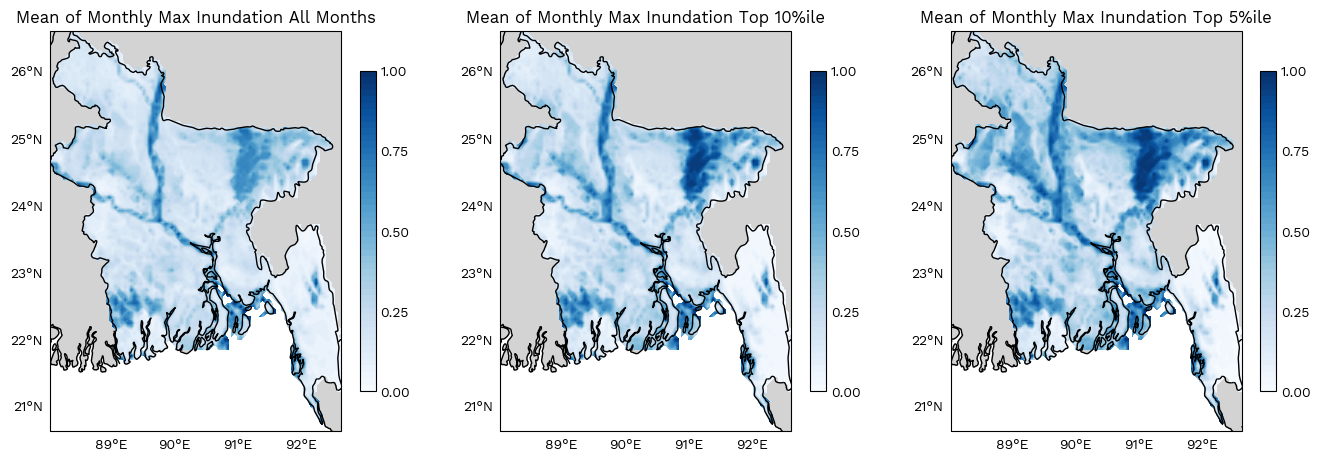

In [76]:
# Define data and arguments for plotting
plotData=[FIAMonthlyMax.mean(dim="time"), FIAMonthlyMaxComp, FIAMonthlyMaxComp2]
coordsData=FIAMonthlyMaxComp
titleName=['Mean of Monthly Max Inundation All Months', 'Mean of Monthly Max Inundation Top 10%ile', 'Mean of Monthly Max Inundation Top 5%ile']
vmin, vmax, nlevels, nlevelsCbar = 0, 1, 51, 5
cmap='Blues'#'PuOr_r'#'Spectral_r'
levels = np.linspace(vmin, vmax, nlevels)
EOFsToPlot=3
ncolsToPlot=3
nrowsToPlot=math.ceil(EOFsToPlot/ncolsToPlot)
colSize=4.5
extentBuffer=0
plotExtent = [coordsData.lon.min().values - extentBuffer, coordsData.lon.max().values + extentBuffer, coordsData.lat.min().values - extentBuffer, coordsData.lat.max().values + extentBuffer]
centerLon = 90

# Plot
fig, axes = plt.subplots(nrowsToPlot, ncolsToPlot, figsize=(colSize*ncolsToPlot, colSize*nrowsToPlot), constrained_layout=True, subplot_kw={'projection': ccrs.Miller(central_longitude=centerLon)})

for i, ax in enumerate(axes.ravel()):
    amin, amax = np.nanmin(plotData[i]), np.nanmax(plotData[i])
    extend=getExtend(amin, amax, vmin, vmax)
    ax.set_title('{0}'.format(titleName[i]))#, fontsize=16)
    ax.coastlines(color='black') 
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.BORDERS)
    ax.set_extent(plotExtent, crs=ccrs.PlateCarree())
    gl1 = ax.gridlines(color='k', linestyle='--', draw_labels=["left", "bottom"], x_inline=False,
                      y_inline=False, ylocs=list(range(20, 28, 1)), xlocs=list(range(88, 94, 1)))
    gl1.xlines=False
    gl1.ylines=False
    eofPlot = ax.contourf(coordsData.lon, coordsData.lat, plotData[i], cmap=cmap, transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax, extend=extend, levels=levels)
    cb1 = plt.colorbar(eofPlot, orientation='vertical', ticks=np.linspace(vmin, vmax, nlevelsCbar), shrink=0.8)
    cb1.ax.tick_params(size=0)